# Statistical Debugging

In this chapter, we introduce _statistical debugging_ – the idea that specific events during execution could be _statistically correlated_ with failures. We start with coverage of individual lines and then proceed towards further execution features.

In [1]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.StatisticalDebugger import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

For instance, this is what we get for `x=1`:

You can use `int_fuzzer()` as:

```python
>>> print(2 + 2)
4
```


## Introduction

The idea behind _statistical debugging_ is fairly simple. We have a program that sometimes passes and sometimes fails. This outcome can be _correlated_ with events that precede it – properties of the input, properties of the execution, properties of the program state. If we, for instance, can find that "the program always fails when Line 123 is executed, and it always passes when Line 123 is _not_ executed", then we have a strong correlation between Line 123 being executed and failure.

Such _correlation_ does not necessarily mean _causation_. For this, we would have to prove that executing Line 123 _always_ leads to failure, and that _not_ executing it does not lead to (this) failure. Also, a correlation (or even a causation) does not mean that Line 123 contains the defect – for this, we would have to show that it actually is an error. Still, correlations make excellent hints as it comes to search for failure causes – in all generality, if you let your search be guided by _events that correlate with failures_, you are more likely to find _important hints on how the failure comes to be_.

## Collecting Events

How can we determine events that correlate with failure? We start with a general mechanism to actually _collect_ events during execution. The abstract `Collector` class provides

* a `collect()` method made for collecting events, called from the `traceit()` tracer; and
* an `events()` method made for retrieving these events.

Both of these are _abstract_ and will be defined further in subclasses.

In [2]:
from Tracer import Tracer

In [3]:
class Collector(Tracer):
    """A class to record events during execution."""

    def collect(self, frame, event, arg):
        """Collecting function. To be overridden in subclasses."""
        pass

    def events(self):
        """Return a collection of events. To be overridden in subclasses."""
        return set()

    def traceit(self, frame, event, arg):
        self.collect(frame, event, arg)

A `Collector` class is used like `Tracer`, using a `with` statement. Let us apply it on the buggy variant of `remove_html_markup()` from the [Introduction to Debugging](Intro_Debugging.ipynb):

In [4]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [5]:
c = Collector()
with c:
    out = remove_html_markup('"foo"')
out

'foo'

There's not much we can do with our collector, as the `collect()` and `events()` methods are yet empty. However, we can introduce an `id()` method which returns a string identifying the collector. This string is defined from the _first function call_ encountered.

In [6]:
class Collector(Collector):
    def __init__(self):
        self._id = None

    def traceit(self, frame, event, arg):
        if self._id is None and event == 'call':
            # Save ID
            function = frame.f_code.co_name
            locals = frame.f_locals
            args = ", ".join([f"{var}={repr(locals[var])}" for var in locals])
            self._id = f"{function}({args})"

        self.collect(frame, event, arg)

    def id(self):
        return self._id

In [7]:
c = Collector()
with c:
    remove_html_markup('abc')
c.id()

"remove_html_markup(s='abc')"

## Collecting Coverage

So far, our `Collector` class does not collect any events. Let us extend it such that it collects _coverage_ information – that is, the set of lines executed. To this end, we introduce a `CoverageCollector` subclass which saves the coverage in a set:

In [8]:
class CoverageCollector(Collector):
    """A class to record covered lines during execution."""

    def __init__(self):
        super().__init__()
        self.coverage = set()

    def collect(self, frame, event, arg):
        self.coverage.add(frame.f_lineno)

We also override `events()` such that it returns the set of covered lines.

In [9]:
class CoverageCollector(CoverageCollector):
    def events(self):
        """Return a set of predicates holding for the execution"""
        return self.coverage

Here is how we can use `CoverageCollector` to determine the lines executed during a run of `remove_html_markup()`:

In [10]:
c = CoverageCollector()
with c:
    remove_html_markup('abc')
print(c.events())

{1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16}


Sets of line numbers alone are not too revealing. They provide more insights if we actually list the code, highlighting these numbers:

In [11]:
import inspect

In [12]:
from bookutils import getsourcelines    # like inspect.getsourcelines(), but in color

In [13]:
def list_with_coverage(function, coverage):
    source_lines, starting_line_number = \
       getsourcelines(function)

    line_number = starting_line_number
    for line in source_lines:
        marker = '*' if line_number in coverage else ' '
        print(f"{line_number:4} {marker} {line}", end='')
        line_number += 1

In [14]:
list_with_coverage(remove_html_markup, c.coverage)

   1 * def remove_html_markup(s):
   2 *     tag = False
   3 *     quote = False
   4 *     out = ""
   5   
   6 *     for c in s:
   7 *         if c == '<' and not quote:
   8               tag = True
   9 *         elif c == '>' and not quote:
  10               tag = False
  11 *         elif c == '"' or c == "'" and tag:
  12               quote = not quote
  13 *         elif not tag:
  14 *             out = out + c
  15   
  16 *     return out


Remember that the input `s` was `"abc"`? In this listing, we can see which lines were covered and which lines were not. From the listing already, we can see that `s` has neither tags nor quotes.

Such coverage computation plays a big role in _testing_, as one wants tests to cover as many different aspects of program execution (and notably code) as possible. But also during debugging, code coverage is essential: If some code was not even executed in the failing run, then any change to it will have no effect.

In [15]:
from bookutils import quiz

In [16]:
quiz("Let the input be <samp>&quot;&lt;b&gt;Don't do this!&lt;/b&gt;&quot;</samp>. "
     "Which of these lines are executed? Use the code to find out!",
     [
         "<samp>tag = True</samp>",
         "<samp>tag = False</samp>",
         "<samp>quote = not quote</samp>",
         "<samp>out = out + c</samp>"
     ], [ord(c) - ord('a') - 1 for c in 'cdf'])

To find the solution, try this out yourself:

In [17]:
c = CoverageCollector()
with c:
    remove_html_markup("<b>Don't do this!</b>")
# list_with_coverage(remove_html_markup, c.coverage)

## Computing Differences

Let us get back to the idea that we want to _correlate_ events with passing and failing outcomes. For this, we need to examine events in both _passing_ and _failing_ runs, and determine their _differences_ – since it is these differences we want to associate with their respective outcome.

### A Base Class for Statistical Debugging

The `StatisticalDebugger` base class takes a collector class (such as `CoverageCollector`). Its `collect()` method creates a new collector of that very class, which will be maintained by the debugger. As argument, `collect()` takes a string characterizing the outcome (such as `'PASS'` or `'FAIL'`). This is how one would use it:

```python
debugger = StatisticalDebugger(CoverageCollector)
with debugger.collect('PASS'):
    some_passing_run()
with debugger.collect('PASS'):
    another_passing_run()
with debugger.collect('FAIL'):
    some_failing_run()
```

Let us implement `StatisticalDebugger`. The base class gets a collector class as argument:

In [18]:
class StatisticalDebugger():
    """A class to collect events for multiple outcomes."""

    def __init__(self, collector_class):
        self.collector_class = collector_class
        self.collectors = {}

The `collect()` method creates (and stores) a collector for the given outcome, using the given outcome to characterize the run. Any additional arguments are passed to the collector.

In [19]:
class StatisticalDebugger(StatisticalDebugger):
    def collect(self, outcome, *args):
        collector = self.collector_class(*args)
        if outcome not in self.collectors:
            self.collectors[outcome] = []
        self.collectors[outcome].append(collector)
        return collector

Here's a simple example of `StatisticalDebugger` in action:

In [20]:
s = StatisticalDebugger(CoverageCollector)
with s.collect('PASS'):
    remove_html_markup("abc")
with s.collect('PASS'):
    remove_html_markup('<b>abc</b>')
with s.collect('FAIL'):
    remove_html_markup('"foo"')

The attribute `collectors` maps outcomes to lists of collectors:

In [21]:
s.collectors

{'PASS': [<__main__.CoverageCollector at 0x7fc13d39bc88>,
 'FAIL': [<__main__.CoverageCollector at 0x7fc13d39b198>]}

Here's the collector of the one (and first) passing run:

In [22]:
s.collectors['PASS'][0].id()

"remove_html_markup(s='abc')"

In [23]:
s.collectors['PASS'][0].events()

{1, 2, 3, 4, 6, 7, 9, 11, 13, 14, 16}

To better highlight the differences between the collected events, we introduce a method `event_table()` that prints out whether an event took place in a run.

### Excursion: Printing an Event Table

In [24]:
from IPython.display import display, Markdown, HTML

In [25]:
class StatisticalDebugger(StatisticalDebugger):
    def event_table(self, show_ids=False):
        sep = ' | '

        all_events = set()
        for name in self.collectors:
            for collector in self.collectors[name]:
                all_events.update(collector.events())

        longest_event = max(len(f"{event}") for event in all_events)

        out = ""

        # Header
        if show_ids:
            out += '| ' + ' ' * longest_event + sep
            for name in self.collectors:
                for collector in self.collectors[name]:
                    out += '`' + collector.id() + '`' + sep
            out += '\n'
        else:
            out += '| ' + ' ' * longest_event + sep
            for name in self.collectors:
                for i in range(len(self.collectors[name])):
                    out += name + sep
            out += '\n'

        out += '| ' + '-' * longest_event + sep
        for name in self.collectors:
            for i in range(len(self.collectors[name])):
                out += '-' * len(name) + sep
        out += '\n'

        # Data
        for event in all_events:
            out += f"| {repr(event).rjust(longest_event)}" + sep
            for name in self.collectors:
                for collector in self.collectors[name]:
                    out += ' ' * (len(name) - 1)
                    if event in collector.events():
                        out += "X"
                    else:
                        out += "-"
                    out += sep
            out += '\n'

        return Markdown(out)

### End of Excursion

In [26]:
s = StatisticalDebugger(CoverageCollector)
with s.collect('PASS'):
    remove_html_markup("abc")
with s.collect('PASS'):
    remove_html_markup('<b>abc</b>')
with s.collect('FAIL'):
    remove_html_markup('"foo"')
s.event_table(show_ids=True)

|    | `remove_html_markup(s='abc')` | `remove_html_markup(s='<b>abc</b>')` | `remove_html_markup(s='"foo"')` | 
| -- | ---- | ---- | ---- | 
|  1 |    X |    X |    X | 
|  2 |    X |    X |    X | 
|  3 |    X |    X |    X | 
|  4 |    X |    X |    X | 
|  6 |    X |    X |    X | 
|  7 |    X |    X |    X | 
|  8 |    - |    X |    - | 
|  9 |    X |    X |    X | 
| 10 |    - |    X |    - | 
| 11 |    X |    X |    X | 
| 12 |    - |    - |    X | 
| 13 |    X |    X |    X | 
| 14 |    X |    X |    X | 
| 16 |    X |    X |    X | 


In [27]:
quiz("How many lines are executed in the failing run only?",
    ["One", "Two", "Three"], int(chr(50)))

These lines only executed in the failing run would be a correlation to look for.

### Collecting Passing and Failing Runs

While our `StatisticalDebugger` class allows arbitrary outcomes, we are typically only interested in two outcomes, namely _passing_ vs. _failing_ runs. We therefore introduce a specialized `DifferenceDebugger()` class that provides customized methods to collect and access passing and failing runs.

In [28]:
class DifferenceDebugger(StatisticalDebugger):
    """A class to collect events for passing and failing outcomes."""

    PASS = 'PASS'
    FAIL = 'FAIL'

    def collect_pass(self):
        return self.collect(self.PASS)
    def collect_fail(self):
        return self.collect(self.FAIL)

    def pass_collectors(self):
        return self.collectors[self.PASS]
    def fail_collectors(self):
        return self.collectors[self.FAIL]

Here's how to use `DifferenceDebugger`:

In [29]:
def test_debugger_html(debugger):
    with debugger.collect_pass():
        remove_html_markup('abc')
    with debugger.collect_pass():
        remove_html_markup('<b>abc</b>')
    with debugger.collect_fail():
        remove_html_markup('"foo"')
    return debugger

In [30]:
debugger = test_debugger_html(DifferenceDebugger(CoverageCollector))

Since events come back as _sets_, we can compute _unions_ and _differences_ between these sets. For instance, we can compute which lines were executed in _any_ of the passing runs:

In [31]:
pass_1_events = debugger.pass_collectors()[0].events()

In [32]:
pass_2_events = debugger.pass_collectors()[1].events()

In [33]:
in_any_pass = pass_1_events | pass_2_events
in_any_pass

{1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 16}

Likewise, we can determine which lines were _only_ executed in the failing run:

In [34]:
fail_events = debugger.fail_collectors()[0].events()

In [35]:
only_in_fail = fail_events - in_any_pass
only_in_fail

{12}

And we see that the "failing" run is characterized by processing quotes:

In [36]:
list_with_coverage(remove_html_markup, only_in_fail)

   1   def remove_html_markup(s):
   2       tag = False
   3       quote = False
   4       out = ""
   5   
   6       for c in s:
   7           if c == '<' and not quote:
   8               tag = True
   9           elif c == '>' and not quote:
  10               tag = False
  11           elif c == '"' or c == "'" and tag:
  12 *             quote = not quote
  13           elif not tag:
  14               out = out + c
  15   
  16       return out


Let us add a few helper methods that return computations such as the above. The `all_events()` method produces a union of all events. If an outcome is given, it produces a union of all events with that outcome:

In [37]:
class DifferenceDebugger(DifferenceDebugger):
    def all_events(self, outcome=None):
        in_any = set()
        if outcome:
            for collector in self.collectors[outcome]:
                in_any.update(collector.events())
        else:
            for outcome in self.collectors:
                for collector in self.collectors[outcome]:
                    in_any.update(collector.events())
        return in_any

    def all_fail(self):
        return self.all_events(self.FAIL)

    def all_pass(self):
        return self.all_events(self.PASS)

We can now introduce helper methods that show the events occurring only in passing and failing runs, respectively:

In [38]:
class DifferenceDebugger(DifferenceDebugger):
    def only_fail(self):
        return self.all_fail() - self.all_pass()

    def only_pass(self):
        return self.all_pass() - self.all_fail()

In [39]:
debugger = test_debugger_html(DifferenceDebugger(CoverageCollector))

In [40]:
debugger.all_events()

{1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16}

These are the lines executed only in the failing run:

In [41]:
debugger.only_fail()

{12}

These are the lines executed only in the passing runs:

In [42]:
debugger.only_pass()

{8, 10}

Again, having these lines individually is neat, but things become much more interesting if we can see the associated code lines just as well. That's what we will do in the next section.

## Visualizing Differences

To show correlations of line coverage in context, we introduce a number of _visualization_ techniques that _highlight_ code with different colors.

### Discrete Spectrum

The first idea is to use a _discrete_ spectrum of three colors:

* _red_ for code executed in failing runs only
* _green_ for code executed in passing runs only
* _yellow_ for code executed in both passing and failing runs.

Code that is not executed stays unhighlighted.

Our `DiscreteSpectrumDebugger` subclass provides a `color()` method that returns one of these three colors depending on the line number:

In [43]:
class DiscreteSpectrumDebugger(DifferenceDebugger):
    def color(self, line_number):
        passing = self.all_pass()
        failing = self.all_fail()

        if line_number in passing and line_number in failing:
            return 'lightyellow'
        elif line_number in failing:
            return 'mistyrose'
        elif line_number in passing:
            return 'honeydew'
        else:
            return None

The `list_with_spectrum()` method takes a function and shows each of its source code lines using the given spectrum, using HTML markup:

In [44]:
class DiscreteSpectrumDebugger(DiscreteSpectrumDebugger):
    def list_with_spectrum(self, function, show_color=False):
        source_lines, starting_line_number = \
           inspect.getsourcelines(function)

        line_number = starting_line_number
        out = ""
        for line in source_lines:
            if line.strip() == '':
                line = '&nbsp;'

            line = str(line_number).rjust(4) + ' ' + line
            color = self.color(line_number)

            if show_color:
                line = f'{repr(color):15} {line}'

            if color:
                line = f'<pre style="background-color:{color}">' \
                        f'{line.rstrip()}</pre>'
            else:
                line = f'<pre>{line}</pre>'
                
            out += line
            line_number += 1

        return HTML(out)

This is how the `only_pass()` and `only_fail()` sets look like when visualized with code. The "culprit" line is well highlighted:

In [45]:
debugger = test_debugger_html(DiscreteSpectrumDebugger(CoverageCollector))

In [46]:
debugger.list_with_spectrum(remove_html_markup)

We can clearly see that the failure is correlated with the presence of quotes in the input string (which is an important hint!). But does this also show us _immediately_ where the defect to be fixed is?

In [47]:
quiz("Does the line <samp>quote = not quote</samp> actually contain the defect?",
    [
        "Yes, it should be fixed",
        "No, the defect is elsewhere"
    ],
     164 * 2 % 326
    )

Indeed, it is the preceding condition that is wrong. In order to fix a program, we have to find a location that

1. _causes_ the failure (i.e., it can be changed to make the failure go away); and
2. is a _defect_ (i.e., contains an error).

In our example above, the highlighted code line is a _symptom_ for the error. To some extent, it is also a _cause_, since, say, commenting it out would also resolve the given failure, at the cost of causing other failures. However, the preceding condition also is a cause, as is the presence of quotes in the input.

Only one of these also is a _defect_, though, and that is the preceding condition. Hence, while correlations can provide important hints, they do not necessarily locate defects.

### Continuous Spectrum

The criterion that an event should _only_ occur in failing runs (and not in passing runs) can be too aggressive. In particular, if we have another run that executes the "culprit" lines, but does _not_ fail, our "only in fail" criterion will no longer be helpful.

Here is an example. The input

```html
<b color="blue">text</b>
```

will trigger the "culprit" line

```python
quote = not quote
```

but actually produce an output where the tags are properly stripped:

In [48]:
remove_html_markup('<b color="blue">text</b>')

'text'

As a consequence, we no longer have lines that are being executed only in failing runs:

In [49]:
debugger = test_debugger_html(DiscreteSpectrumDebugger(CoverageCollector))
with debugger.collect_pass():
    remove_html_markup('<b link="blue"></b>')

In [50]:
debugger.only_fail()

set()

In our spectrum output, the effect now is that the "culprit" line is as yellow as all others.

In [51]:
debugger.list_with_spectrum(remove_html_markup)

We therefore introduce a different method for highlighting lines, based on their _relative_ occurrence with respect to all runs: If a line has been _mostly_ executed in failing runs, its color should shift towards red; if a line has been _mostly_ executed in passing runs, its color should shift towards green.

This _continuous spectrum_ has been introduced by the seminal _Tarantula_ tool. In Tarantula, the color _hue_ for each line is defined as follows:

$$\textit{color hue}(\textit{line}) = \textit{low color(red)} + \frac{\%\textit{passed}(\textit{line})}{\%\textit{passed}(\textit{line}) + \%\textit{failed}(\textit{line})} \times \textit{color range}$$

Here, `%passed` and `%failed` denote the percentage at which a line has been executed in passing and failing runs, respectively. A hue of 0.0 stands for red, a hue of 1.0 stands for green, and a hue of 0.5 stands for equal fractions of red and green, yielding yellow.

We can implement these measures right away as methods in a new `ContinuousSpectrumDebugger` class:

In [52]:
class ContinuousSpectrumDebugger(DiscreteSpectrumDebugger):
    def event_fraction(self, event, category):
        all_runs = self.collectors[category]
        runs_with_event = set(collector for collector in all_runs 
                              if event in collector.events())
        fraction = len(runs_with_event) / len(all_runs)
        # print(f"%{category}({event}) = {fraction}")
        return fraction

    def passed(self, line_number):
        return self.event_fraction(line_number, self.PASS)

    def failed(self, line_number):
        return self.event_fraction(line_number, self.FAIL)

    def hue(self, line_number):
        passed = self.passed(line_number)
        failed = self.failed(line_number)
        if passed + failed > 0:
            return passed / (passed + failed)
        else:
            return None

The hue for lines executed only in failing runs is (deep) red, as expected:

In [53]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))

In [54]:
for line in debugger.only_fail():
    print(line, debugger.hue(line))

12 0.0


Likewise, the hue for lines executed in passing runs is (deep) green:

In [55]:
for line in debugger.only_pass():
    print(line, debugger.hue(line))

8 1.0
10 1.0


The Tarantula tool not only sets the hue for a line, but also uses _brightness_ as measure for support – that is, how often was the line executed at all. The brighter a line, the stronger the correlation with a passing or failing outcome.

The brightness is defined as follows:

$$\textit{bright}(line) = \max(\%\textit{passed}(\textit{line}), \%\textit{failed}(\textit{line}))$$

and it is easily implemented, too:

In [56]:
class ContinuousSpectrumDebugger(ContinuousSpectrumDebugger):
    def bright(self, line):
        return max(self.passed(line), self.failed(line))

Our single "only in fail" line has a brightness of 1.0 (the maximum).

In [57]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))
for line in debugger.only_fail():
    print(line, debugger.bright(line))

12 1.0


With this, we can now define a color for each line. To this end, we override the (previously discrete) `color()` method such that it returns a color specification giving hue and brightness. We use the HTML format `hsl(hue, saturation, lightness)` where the hue is given as a value between 0 and 360 (0 is red, 120 is green) and saturation and lightness are provided as percentages.

In [58]:
class ContinuousSpectrumDebugger(ContinuousSpectrumDebugger):
    def color(self, line):
        hue = debugger.hue(line)
        if hue is None:
            return None
        saturation = debugger.bright(line)

        # HSL color values are specified with: 
        # hsl(hue, saturation, lightness).
        return f"hsl({hue * 120}, {saturation * 100}%, 80%)"

In [59]:
debugger = test_debugger_html(ContinuousSpectrumDebugger(CoverageCollector))

Lines executed only in failing runs are still shown in red:

In [60]:
for line in debugger.only_fail():
    print(line, debugger.color(line))

12 hsl(0.0, 100.0%, 80%)


... whereas lines executed only in passing runs are still shown in green:

In [61]:
for line in debugger.only_pass():
    print(line, debugger.color(line))

8 hsl(120.0, 50.0%, 80%)
10 hsl(120.0, 50.0%, 80%)


In [62]:
debugger.list_with_spectrum(remove_html_markup)

What happens with our `quote = not quote` "culprit" line if it is executed in passing runs, too?

In [63]:
with debugger.collect_pass():
    out = remove_html_markup('<b link="blue"></b>')

In [64]:
quiz("In which color will the <samp>quote = not quote</samp> be shown after executing the above line?",
    [
        '<span style="background-color: hsl(120.0, 50.0%, 80%)">Green</span>',
        '<span style="background-color: hsl(60.0, 100.0%, 80%)">Yellow</span>',
        '<span style="background-color: hsl(30.0, 100.0%, 80%)">Orange</span>',
        '<span style="background-color: hsl(0.0, 100.0%, 80%)">Red</span>'
    ],
     999 / 333
    )

We see that it still is shown with an orange-red tint.

In [65]:
debugger.list_with_spectrum(remove_html_markup)

Here's another example, coming right from the Tarantula paper. The `middle()` function takes three numbers `x`, `y`, and `z`, and returns the one that is neither the minimum nor the maximum of the three:

In [66]:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

In [67]:
middle(1, 2, 3)

2

Unfortunately, `middle()` can fail:

In [68]:
middle(2, 1, 3)

1

Let is see whether we can find the bug with a few additional test cases:

In [69]:
def test_debugger_middle(debugger):
    with debugger.collect_pass():
        middle(3, 3, 5)
    with debugger.collect_pass():
        middle(1, 2, 3)
    with debugger.collect_pass():
        middle(3, 2, 1)
    with debugger.collect_pass():
        middle(5, 5, 5)
    with debugger.collect_pass():
        middle(5, 3, 4)
    with debugger.collect_fail():
        middle(2, 1, 3)
    return debugger

Note that in order to collect data from multiple function invocations, you need to have a separate `with` clause for every invocation. The following will _not_ work correctly:

```python
    with debugger.collect_pass():
        middle(3, 3, 5)
        middle(1, 2, 3)
        ...
```

In [70]:
debugger = test_debugger_middle(ContinuousSpectrumDebugger(CoverageCollector))

In [71]:
debugger.event_table()

|    | PASS | PASS | PASS | PASS | PASS | FAIL | 
| -- | ---- | ---- | ---- | ---- | ---- | ---- | 
|  1 |    X |    X |    X |    X |    X |    X | 
|  2 |    X |    X |    X |    X |    X |    X | 
|  3 |    X |    X |    - |    - |    X |    X | 
|  4 |    - |    X |    - |    - |    - |    - | 
|  5 |    X |    - |    - |    - |    X |    X | 
|  6 |    X |    - |    - |    - |    - |    X | 
|  8 |    - |    - |    X |    X |    - |    - | 
|  9 |    - |    - |    X |    - |    - |    - | 
| 10 |    - |    - |    - |    X |    - |    - | 
| 12 |    - |    - |    - |    X |    X |    - | 


Here us the visualization. We see that the `return y` line is the culprit here – and actually also the one to be fixed.

In [72]:
debugger.list_with_spectrum(middle)

In [73]:
# quiz("How to fix this?")

## Ranking Lines by Suspiciousness

### The Tarantula Metric

### The Ochiai Metric

### How Effective is Ranking?

## Other Events besides Coverage

Our framework allows for tracking arbitrary events, not just coverage.

In [74]:
class ValueCollector(Collector):
    def __init__(self):
        super().__init__()
        self.vars = set()

    def collect(self, frame, event, arg):
        local_vars = frame.f_locals
        for var in local_vars:
            value = local_vars[var]
            self.vars.add((var, value))

    def events(self):
        return self.vars

In [75]:
debugger = test_debugger_html(DifferenceDebugger(ValueCollector))
debugger.event_table()

|                     | PASS | PASS | FAIL | 
| ------------------- | ---- | ---- | ---- | 
|          ('c', 'a') |    X |    X |    - | 
|      ('out', 'abc') |    X |    X |    - | 
| ('s', '<b>abc</b>') |    - |    X |    - | 
|          ('c', 'c') |    X |    X |    - | 
|          ('c', 'o') |    - |    - |    X | 
|          ('c', 'f') |    - |    - |    X | 
|       ('out', 'fo') |    - |    - |    X | 
|        ('out', 'a') |    X |    X |    - | 
|      ('s', '"foo"') |    - |    - |    X | 
|    ('quote', False) |    X |    X |    X | 
|         ('out', '') |    X |    X |    X | 
|          ('c', '<') |    - |    X |    - | 
|       ('tag', True) |    - |    X |    - | 
|        ('out', 'f') |    - |    - |    X | 
|          ('c', '>') |    - |    X |    - | 
|          ('c', '/') |    - |    X |    - | 
|     ('quote', True) |    - |    - |    X | 
|          ('c', 'b') |    X |    X |    - | 
|      ('out', 'foo') |    - |    - |    X | 
|          ('c', '"') |    - |    - |    X | 
|       ('out', 'ab') |    X |    X |    - | 
|      ('tag', False) |    X |    X |    X | 
|        ('s', 'abc') |    X |    - |    - | 


In [76]:
debugger.only_fail()

{('c', '"'),
 ('c', 'f'),
 ('c', 'o'),
 ('out', 'f'),
 ('out', 'fo'),
 ('out', 'foo'),
 ('quote', True),
 ('s', '"foo"')}

In [77]:
debugger = test_debugger_middle(DifferenceDebugger(ValueCollector))
debugger.event_table()

|          | PASS | PASS | PASS | PASS | PASS | FAIL | 
| -------- | ---- | ---- | ---- | ---- | ---- | ---- | 
| ('z', 4) |    - |    - |    - |    - |    X |    - | 
| ('x', 2) |    - |    - |    - |    - |    - |    X | 
| ('z', 5) |    X |    - |    - |    X |    - |    - | 
| ('x', 5) |    - |    - |    - |    X |    X |    - | 
| ('y', 5) |    - |    - |    - |    X |    - |    - | 
| ('x', 3) |    X |    - |    X |    - |    - |    - | 
| ('y', 2) |    - |    X |    X |    - |    - |    - | 
| ('y', 3) |    X |    - |    - |    - |    X |    - | 
| ('z', 1) |    - |    - |    X |    - |    - |    - | 
| ('x', 1) |    - |    X |    - |    - |    - |    - | 
| ('y', 1) |    - |    - |    - |    - |    - |    X | 
| ('z', 3) |    - |    X |    - |    - |    - |    X | 


In [78]:
debugger.only_fail()

{('x', 2), ('y', 1)}

### Training a Classifier

In [79]:
from sklearn import tree

In [80]:
class ClassifyingDebugger(DifferenceDebugger):
    PASS_VALUE = +1
    FAIL_VALUE = -1

    def samples(self):
        samples = {}
        for collector in self.pass_collectors():
            samples[collector.id()] = self.PASS_VALUE
        for collector in debugger.fail_collectors():
            samples[collector.id()] = self.FAIL_VALUE
        return samples

In [81]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.samples()

{'middle(z=5, y=3, x=3)': 1,
 'middle(z=3, y=2, x=1)': 1,
 'middle(z=1, y=2, x=3)': 1,
 'middle(z=5, y=5, x=5)': 1,
 'middle(z=4, y=3, x=5)': 1,
 'middle(z=3, y=1, x=2)': -1}

In [82]:
class ClassifyingDebugger(ClassifyingDebugger):
    def features(self):
        features = {}
        for collector in debugger.pass_collectors():
            features[collector.id()] = collector.events()
        for collector in debugger.fail_collectors():
            features[collector.id()] = collector.events()
        return features

In [83]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.features()

{'middle(z=5, y=3, x=3)': {1, 2, 3, 5, 6},
 'middle(z=3, y=2, x=1)': {1, 2, 3, 4},
 'middle(z=1, y=2, x=3)': {1, 2, 8, 9},
 'middle(z=5, y=5, x=5)': {1, 2, 8, 10, 12},
 'middle(z=4, y=3, x=5)': {1, 2, 3, 5, 12},
 'middle(z=3, y=1, x=2)': {1, 2, 3, 5, 6}}

In [84]:
class ClassifyingDebugger(ClassifyingDebugger):
    def feature_names(self):
        return [repr(feature) for feature in self.all_events()]

In [85]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.feature_names()

['1', '2', '3', '4', '5', '6', '8', '9', '10', '12']

In [86]:
class ClassifyingDebugger(ClassifyingDebugger):
    def shape(self, sample):
        x = []
        features = self.features()
        for f in self.all_events():
            if f in features[sample]:
                x += [+1]
            else:
                x += [-1]
        return x

In [87]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.shape('middle(z=5, y=3, x=3)')

[1, 1, 1, -1, 1, 1, -1, -1, -1, -1]

In [88]:
class ClassifyingDebugger(ClassifyingDebugger):
    def X(self):
        X = []
        samples = self.samples()
        for key in samples:
            X += [self.shape(key)]
        return X

In [89]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.X()

[[1, 1, 1, -1, 1, 1, -1, -1, -1, -1],
 [1, 1, 1, 1, -1, -1, -1, -1, -1, -1],
 [1, 1, -1, -1, -1, -1, 1, 1, -1, -1],
 [1, 1, -1, -1, -1, -1, 1, -1, 1, 1],
 [1, 1, 1, -1, 1, -1, -1, -1, -1, 1],
 [1, 1, 1, -1, 1, 1, -1, -1, -1, -1]]

In [90]:
class ClassifyingDebugger(ClassifyingDebugger):
    def Y(self):
        Y = []
        samples = self.samples()
        for key in samples:
            Y += [samples[key]]
        return Y

In [91]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
debugger.Y()

[1, 1, 1, 1, 1, -1]

In [92]:
class ClassifyingDebugger(ClassifyingDebugger):
    def classifier(self):
        classifier = tree.DecisionTreeClassifier()
        classifier = classifier.fit(self.X(), self.Y())
        return classifier

In [93]:
import graphviz

In [94]:
class ClassifyingDebugger(ClassifyingDebugger):
    def show_classifier(self, classifier):
        dot_data = tree.export_graphviz(classifier, out_file=None, 
                         filled=False, rounded=True,
                         feature_names=self.feature_names(),
                                class_names=["fail", "pass"],
                                impurity=False,
                         special_characters=True)
        dot_data = dot_data.replace('&le; 0.0', ': no')
        dot_data = dot_data.replace('&ge; 0.0', ': yes')

        return graphviz.Source(dot_data)

This is the tree we get.  A decision like `* <= 0` means that `*` is not part of the input.

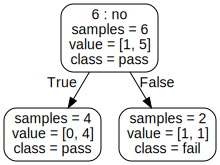

In [95]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
classifier = debugger.classifier()
debugger.show_classifier(classifier)

In [96]:
class ClassifyingDebugger(ClassifyingDebugger):
    def predict(self, classifier, sample):
        return classifier.predict([self.shape(sample)])

In [97]:
debugger = test_debugger_middle(ClassifyingDebugger(CoverageCollector))
# debugger.predict(classifier, set(166))

## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

For instance, this is what we get for `x=1`:

You can use `int_fuzzer()` as:

In [98]:
print(2 + 2)

4


## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [99]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [100]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_